<a href="https://colab.research.google.com/github/Balajinanda/Large-Language-Models/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing libraries**

In [36]:
pip install datasets

In [37]:
# Required libraries
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from transformers import BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader

# **Loading the dataset**

In [38]:
# Load the TREC-6 dataset
dataset = load_dataset('trec')

# Inspect the dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 5452
    })
    test: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 500
    })
})


# **Data Overview**

In [39]:
print(dataset['train'].features)

{'text': Value(dtype='string', id=None), 'coarse_label': ClassLabel(names=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'], id=None), 'fine_label': ClassLabel(names=['ABBR:abb', 'ABBR:exp', 'ENTY:animal', 'ENTY:body', 'ENTY:color', 'ENTY:cremat', 'ENTY:currency', 'ENTY:dismed', 'ENTY:event', 'ENTY:food', 'ENTY:instru', 'ENTY:lang', 'ENTY:letter', 'ENTY:other', 'ENTY:plant', 'ENTY:product', 'ENTY:religion', 'ENTY:sport', 'ENTY:substance', 'ENTY:symbol', 'ENTY:techmeth', 'ENTY:termeq', 'ENTY:veh', 'ENTY:word', 'DESC:def', 'DESC:desc', 'DESC:manner', 'DESC:reason', 'HUM:gr', 'HUM:ind', 'HUM:title', 'HUM:desc', 'LOC:city', 'LOC:country', 'LOC:mount', 'LOC:other', 'LOC:state', 'NUM:code', 'NUM:count', 'NUM:date', 'NUM:dist', 'NUM:money', 'NUM:ord', 'NUM:other', 'NUM:period', 'NUM:perc', 'NUM:speed', 'NUM:temp', 'NUM:volsize', 'NUM:weight'], id=None)}


In [40]:
print(dataset['test'].features)

{'text': Value(dtype='string', id=None), 'coarse_label': ClassLabel(names=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'], id=None), 'fine_label': ClassLabel(names=['ABBR:abb', 'ABBR:exp', 'ENTY:animal', 'ENTY:body', 'ENTY:color', 'ENTY:cremat', 'ENTY:currency', 'ENTY:dismed', 'ENTY:event', 'ENTY:food', 'ENTY:instru', 'ENTY:lang', 'ENTY:letter', 'ENTY:other', 'ENTY:plant', 'ENTY:product', 'ENTY:religion', 'ENTY:sport', 'ENTY:substance', 'ENTY:symbol', 'ENTY:techmeth', 'ENTY:termeq', 'ENTY:veh', 'ENTY:word', 'DESC:def', 'DESC:desc', 'DESC:manner', 'DESC:reason', 'HUM:gr', 'HUM:ind', 'HUM:title', 'HUM:desc', 'LOC:city', 'LOC:country', 'LOC:mount', 'LOC:other', 'LOC:state', 'NUM:code', 'NUM:count', 'NUM:date', 'NUM:dist', 'NUM:money', 'NUM:ord', 'NUM:other', 'NUM:period', 'NUM:perc', 'NUM:speed', 'NUM:temp', 'NUM:volsize', 'NUM:weight'], id=None)}


In [41]:
# Convert dataset to pandas DataFrame
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

# Check the first few rows of the DataFrame to understand the structure
print(train_df.head())
print(test_df.head())

                                                text  coarse_label  fine_label
0  How did serfdom develop in and then leave Russ...             2          26
1   What films featured the character Popeye Doyle ?             1           5
2  How can I find a list of celebrities ' real na...             2          26
3  What fowl grabs the spotlight after the Chines...             1           2
4                    What is the full form of .com ?             0           1
                                       text  coarse_label  fine_label
0      How far is it from Denver to Aspen ?             5          40
1  What county is Modesto , California in ?             4          32
2                         Who was Galileo ?             3          31
3                         What is an atom ?             2          24
4          When did Hawaii become a state ?             5          39


# **EDA Analysis**

In [42]:
# Calculate the frequency of each coarse label for training and test sets
train_label_frequencies = train_df['coarse_label'].value_counts()
test_label_frequencies = test_df['coarse_label'].value_counts()

# Get label names from the dataset
label_names = dataset['train'].features['coarse_label'].int2str

In [43]:
# Create a DataFrame for plotting
train_label_data = pd.DataFrame({
    'Label': train_label_frequencies.index.map(label_names),
    'Count': train_label_frequencies.values
})

# Plot the distribution of coarse labels in the training dataset
train_fig = px.bar(
    train_label_data,
    x='Label',
    y='Count',
    title='Coarse Label Distribution in Training Set',
    labels={'Count': 'Frequency', 'Label': 'Coarse Label'}
)
train_fig.update_layout(xaxis={'categoryorder': 'total descending'})

# Show the figure
train_fig.show()

In [44]:
# Create a DataFrame for plotting
test_label_data = pd.DataFrame({
    'Label': test_label_frequencies.index.map(label_names),
    'Count': test_label_frequencies.values
})

# Plot the distribution of coarse labels in the test dataset
test_fig = px.bar(
    test_label_data,
    x='Label',
    y='Count',
    title='Coarse Label Distribution in Test Set',
    labels={'Count': 'Frequency', 'Label': 'Coarse Label'}
)
test_fig.update_layout(xaxis={'categoryorder': 'total descending'})

# Show the figure
test_fig.show()

In [45]:
# Calculate the length of each text entry (number of tokens)
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
test_df['text_length'] = test_df['text'].apply(lambda x: len(x.split()))

# Get label names from the dataset
label_names = dataset['train'].features['coarse_label'].int2str

# Map label IDs to label names
train_df['Label'] = train_df['coarse_label'].map(label_names)
test_df['Label'] = test_df['coarse_label'].map(label_names)

In [46]:
# Create box plots for the training dataset
train_fig = px.box(
    train_df,
    x='Label',
    y='text_length',
    title='Text Length Distribution by Coarse Label in Training Set',
    labels={'text_length': 'Text Length (Number of Tokens)', 'Label': 'Coarse Label'}
)
train_fig.update_layout(xaxis={'categoryorder': 'total ascending'})
train_fig.show()

In [47]:
# Create box plots for the test dataset
test_fig = px.box(
    test_df,
    x='Label',
    y='text_length',
    title='Text Length Distribution by Coarse Label in Test Set',
    labels={'text_length': 'Text Length (Number of Tokens)', 'Label': 'Coarse Label'}
)
test_fig.update_layout(xaxis={'categoryorder': 'total ascending'})
test_fig.show()

# **Tokenization of dataset**

In [65]:
# Load the tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [66]:
# Define a tokenization function
def tokenize_function(example, tokenizer, padding='max_length', truncation=True, max_length=128):
    """
    Tokenizes the input text using the specified tokenizer.

    Parameters:
    - example: A dictionary containing the text to be tokenized.
    - tokenizer: The tokenizer to be used for tokenization.
    - padding: Type of padding to apply ('max_length', 'longest', or None).
    - truncation: Whether to truncate sequences to fit within the max_length.
    - max_length: The maximum length of sequences after padding/truncation.

    Returns:
    - A dictionary containing the tokenized input_ids, attention_mask, and token_type_ids.
    """
    return tokenizer(
        example['text'],
        padding=padding,
        truncation=truncation,
        max_length=max_length
    )

In [68]:
# Apply the tokenization function to your dataset
tokenized_datasets = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

# Remove the original text column
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

# Rename the labels column
tokenized_datasets = tokenized_datasets.rename_column("coarse_label", "labels")

# Set the format to PyTorch tensors
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/5452 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [69]:
# Inspect the first tokenized example in the training set
print(tokenized_datasets['train'][0])

{'labels': tensor(2), 'fine_label': tensor(26), 'input_ids': tensor([  101,  2129,  2106, 14262,  2546,  9527,  4503,  1999,  1998,  2059,
         2681,  3607,  1029,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
   

In [70]:
# Inspect the first tokenized example in the test set
print(tokenized_datasets['test'][0])

{'labels': tensor(5), 'fine_label': tensor(40), 'input_ids': tensor([  101,  2129,  2521,  2003,  2009,  2013,  7573,  2000, 18567,  1029,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
   

In [52]:
# Assuming 'tokenized_datasets' is already created as shown previously
train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets['test']

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# **Loading BERT Model**

In [75]:
# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

# Move the model to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



# **Training the model**

In [54]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []

# Number of epochs
epochs = 3

# Training loop
model.train()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(train_loader):
        # Move batch to the device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Clear any previously calculated gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Loss computation
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate accuracy
        preds = torch.argmax(outputs.logits, dim=-1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/3


100%|██████████| 171/171 [31:08<00:00, 10.92s/it]


Loss: 0.5745, Accuracy: 0.8153
Epoch 2/3


100%|██████████| 171/171 [34:28<00:00, 12.09s/it]


Loss: 0.1406, Accuracy: 0.9598
Epoch 3/3


100%|██████████| 171/171 [35:36<00:00, 12.49s/it]

Loss: 0.0669, Accuracy: 0.9818


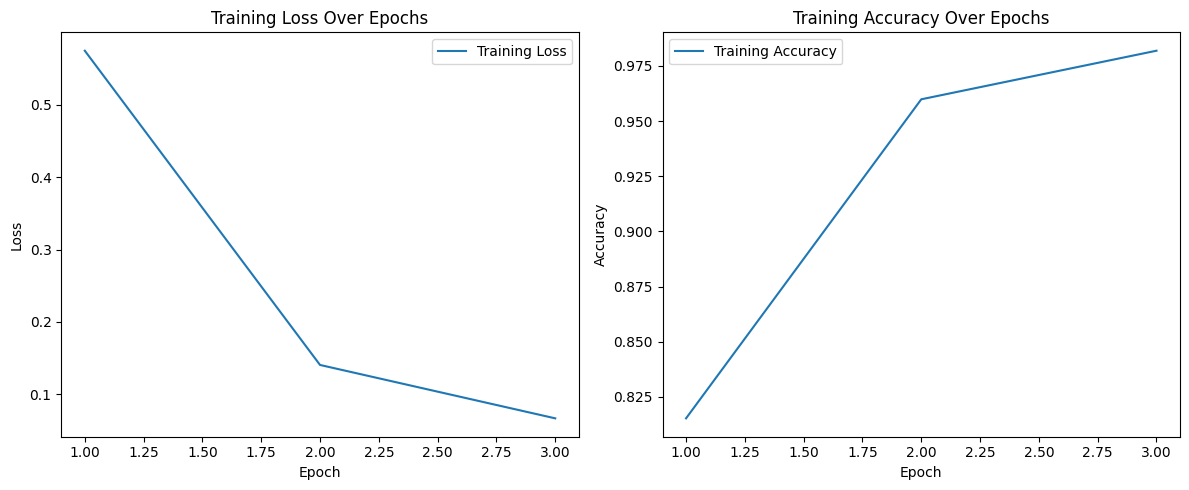

In [61]:
# Plotting accuracy and loss curves
def plot_training_curves(epochs, train_losses, train_accuracies):
    """
    Plots the training loss and accuracy curves.

    Parameters:
    - epochs: Number of epochs (int).
    - train_losses: List of loss values for each epoch.
    - train_accuracies: List of accuracy values for each epoch.
    """
    plt.figure(figsize=(12, 5))

    # Plotting the loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plotting the accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(epochs, train_losses, train_accuracies)

# **Model evaluation**

In [56]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9680


# **Results**

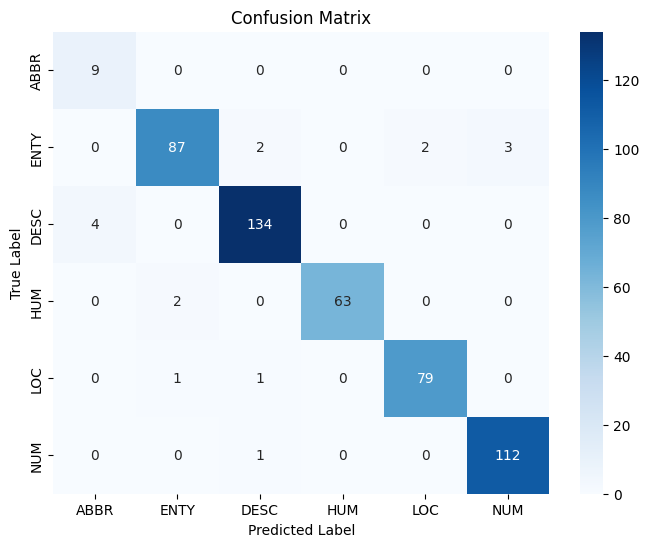

In [57]:
# Ensure label_names is a list of actual label names
label_names = dataset['train'].features['coarse_label'].names

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [58]:
# Classification report
report = classification_report(all_labels, all_preds, target_names=label_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

        ABBR       0.69      1.00      0.82         9
        ENTY       0.97      0.93      0.95        94
        DESC       0.97      0.97      0.97       138
         HUM       1.00      0.97      0.98        65
         LOC       0.98      0.98      0.98        81
         NUM       0.97      0.99      0.98       113

    accuracy                           0.97       500
   macro avg       0.93      0.97      0.95       500
weighted avg       0.97      0.97      0.97       500



# **Example predictions**

In [71]:
# Select 5 random indices from the test set
def print_random_predictions(model, tokenizer, tokenized_dataset, label_names, device, num_samples=5):
    """
    Selects random samples from the test set, makes predictions using the model, and prints the results.

    Parameters:
    - model: The trained BERT model.
    - tokenizer: The tokenizer used to preprocess the text.
    - tokenized_dataset: The tokenized test dataset.
    - label_names: List of label names corresponding to label IDs.
    - device: The device to perform the computations on (e.g., 'cpu' or 'cuda').
    - num_samples: Number of random samples to select and predict (default is 5).
    """
    # Select random indices from the test set
    random_indices = random.sample(range(len(tokenized_dataset)), num_samples)

    # Set model to evaluation mode
    model.eval()

    for idx in random_indices:
        # Get the input data
        input_ids = tokenized_dataset['input_ids'][idx].unsqueeze(0).to(device)
        attention_mask = tokenized_dataset['attention_mask'][idx].unsqueeze(0).to(device)

        # Get the true label
        true_label_id = tokenized_dataset['labels'][idx].item()
        true_label = label_names[true_label_id]

        # Make a prediction
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred_label_id = torch.argmax(outputs.logits, dim=-1).item()
            pred_label = label_names[pred_label_id]

        # Print the results
        original_text = tokenizer.decode(tokenized_dataset['input_ids'][idx], skip_special_tokens=True)
        print(f"Original Text: {original_text}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}\n")


print_random_predictions(model, tokenizer, tokenized_datasets['test'], label_names, device, num_samples=5)

Original Text: what colors need to be mixed to get the color pink?
True Label: ENTY
Predicted Label: ENTY

Original Text: what is strep throat?
True Label: DESC
Predicted Label: DESC

Original Text: how old was elvis presley when he died?
True Label: NUM
Predicted Label: NUM

Original Text: who invented trivial pursuit?
True Label: HUM
Predicted Label: HUM

Original Text: what are the spots on dominoes called?
True Label: ENTY
Predicted Label: ENTY

